In [1]:
# STEP 1: DATA PREPROCESSING

import pandas as pd
import string
import re
from sklearn.feature_extraction import text

# 1. Load your dataset
df = pd.read_csv("SMS_train.csv", encoding='latin1')  # Change path as needed

# 2. Set up stop words
stop_words = text.ENGLISH_STOP_WORDS

# 3. Define a preprocessing function
def preprocess_text(text):
    text = text.lower()  # Lowercase the text
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = text.split()  # Tokenize
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)  # Rejoin the words

# 4. Apply the function to your dataset
df['Cleaned_Message'] = df['Message_body'].astype(str).apply(preprocess_text)

# 5. Preview cleaned data
print(df[['Message_body', 'Cleaned_Message']].head())


                                        Message_body  \
0                         Rofl. Its true to its name   
1  The guy did some bitching but I acted like i'd...   
2  Pity, * was in mood for that. So...any other s...   
3               Will ü b going to esplanade fr home?   
4  This is the 2nd time we have tried 2 contact u...   

                                     Cleaned_Message  
0                                          rofl true  
1  guy did bitching acted like id interested buyi...  
2                        pity mood soany suggestions  
3                        ü b going esplanade fr home  
4  nd time tried contact u u won £ pound prize cl...  


In [2]:
# STEP 2: FEATURE EXTRACTION

from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Get the cleaned message column
X_text = df['Cleaned_Message']

# 2. Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# 3. Fit and transform the text data
X_features = vectorizer.fit_transform(X_text)

# 4. Check the shape of the resulting feature matrix
print("TF-IDF feature matrix shape:", X_features.shape)

# 5. (Optional) View feature names
feature_names = vectorizer.get_feature_names_out()
print("Sample features:", feature_names[:10])


TF-IDF feature matrix shape: (957, 2810)
Sample features: ['aa' 'aah' 'abdomen' 'able' 'absolutely' 'abt' 'accent' 'access'
 'accident' 'accidentally']


In [3]:
# STEP 3: DATA SPLITTING

from sklearn.model_selection import train_test_split

# 1. Target labels (Spam or Non-Spam)
y = df['Label']

# 2. Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_features,  # from Step 2: TF-IDF features
    y,
    test_size=0.2,
    random_state=42,  # ensures reproducibility
    stratify=y        # preserves class distribution
)

# 3. Confirm the split
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)


Training set size: (765, 2810)
Test set size: (192, 2810)


In [4]:
# STEP 4: MODEL SELECTION

from sklearn.naive_bayes import MultinomialNB

# 1. Initialize the Naive Bayes model
model = MultinomialNB()

# 2. Review model parameters (optional)
print(model)


MultinomialNB()


In [5]:
# STEP 5: EXTENDED MODEL TRAINING

# 1. Train the model on the training data
model.fit(X_train, y_train)

# 2. Output training status
print("✅ Model training completed.")

# 3. Inspect learned log priors (class probabilities)
print("\n📊 Log Prior Probabilities (per class):")
classes = model.classes_
log_priors = model.class_log_prior_

for cls, logp in zip(classes, log_priors):
    print(f"  {cls}: {logp:.4f}")

# 4. Optional: Look at top indicative words per class (based on TF-IDF)
import numpy as np

# Get feature names and log probabilities
feature_names = vectorizer.get_feature_names_out()
class_labels = model.classes_
top_n = 10

print("\n🔍 Top indicative words per class:")
for i, class_label in enumerate(class_labels):
    top_features = np.argsort(model.feature_log_prob_[i])[-top_n:][::-1]
    print(f"\n📌 Top words for '{class_label}':")
    for feature_index in top_features:
        print(f"  {feature_names[feature_index]}")


✅ Model training completed.

📊 Log Prior Probabilities (per class):
  Non-Spam: -0.1371
  Spam: -2.0549

🔍 Top indicative words per class:

📌 Top words for 'Non-Spam':
  im
  ok
  just
  later
  come
  got
  oh
  ill
  ltgt
  ur

📌 Top words for 'Spam':
  free
  stop
  mobile
  prize
  claim
  won
  txt
  text
  reply
  shows


In [6]:
# STEP 6: MODEL EVALUATION

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. Predict on the test set
y_pred = model.predict(X_test)

# 2. Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy: {accuracy:.4f}")

# 3. Generate full classification report
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=model.classes_))

# 4. Display confusion matrix
print("\n🧩 Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
cm_df = pd.DataFrame(cm,
                     index=[f"Actual {label}" for label in model.classes_],
                     columns=[f"Predicted {label}" for label in model.classes_])
print(cm_df)


✅ Accuracy: 0.9167

📊 Classification Report:
              precision    recall  f1-score   support

    Non-Spam       0.91      1.00      0.95       168
        Spam       1.00      0.33      0.50        24

    accuracy                           0.92       192
   macro avg       0.96      0.67      0.73       192
weighted avg       0.92      0.92      0.90       192


🧩 Confusion Matrix:
                 Predicted Non-Spam  Predicted Spam
Actual Non-Spam                 168               0
Actual Spam                      16               8


In [7]:
# STEP 7: INFERENCE (PREDICTING NEW MESSAGES)

# 1. Define new messages
new_messages = [
    "Congratulations! You have won a free iPhone. Reply NOW to claim.",
    "Hi! Are we still on for lunch tomorrow?",
    "Your account has been suspended. Call us immediately to reactivate.",
    "Free entry in 2 a weekly competition to win cash!"
]

# 2. Preprocess them using the same function from Step 1
new_cleaned = [preprocess_text(msg) for msg in new_messages]

# 3. Convert them to TF-IDF features using the same vectorizer
new_features = vectorizer.transform(new_cleaned)

# 4. Predict using the trained model
new_predictions = model.predict(new_features)

# 5. Display the results
print("\n📬 New Message Predictions:")
for msg, label in zip(new_messages, new_predictions):
    print(f"\nMessage: {msg}\n➡️ Prediction: {label}")



📬 New Message Predictions:

Message: Congratulations! You have won a free iPhone. Reply NOW to claim.
➡️ Prediction: Spam

Message: Hi! Are we still on for lunch tomorrow?
➡️ Prediction: Non-Spam

Message: Your account has been suspended. Call us immediately to reactivate.
➡️ Prediction: Non-Spam

Message: Free entry in 2 a weekly competition to win cash!
➡️ Prediction: Non-Spam


In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Use raw cleaned messages for X (not pre-vectorized TF-IDF matrix)
X_raw = df['Cleaned_Message']
y = df['Label']

# Split again from scratch (raw input this time)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42, stratify=y)

# Build the pipeline (text -> tfidf -> model)
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Define parameter grid
param_grid = {
    'tfidf__max_df': [0.9, 1.0],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'nb__alpha': [0.5, 1.0, 1.5]
}

# Grid Search with 5-fold cross-validation
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)

# Fit the pipeline
grid.fit(X_train, y_train)

# Show best results
print("✅ Best Parameters:", grid.best_params_)
print("🎯 Best CV F1 Score:", grid.best_score_)

# Evaluate on test set
from sklearn.metrics import classification_report, confusion_matrix

y_pred = grid.predict(X_test)

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("\n🧩 Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred, labels=grid.best_estimator_.classes_)
print(pd.DataFrame(cm,
                   index=[f"Actual {l}" for l in grid.best_estimator_.classes_],
                   columns=[f"Predicted {l}" for l in grid.best_estimator_.classes_]))


✅ Best Parameters: {'nb__alpha': 0.5, 'tfidf__max_df': 0.9, 'tfidf__ngram_range': (1, 1)}
🎯 Best CV F1 Score: 0.8449485889934698

📊 Classification Report:
              precision    recall  f1-score   support

    Non-Spam       0.95      1.00      0.98       168
        Spam       1.00      0.67      0.80        24

    accuracy                           0.96       192
   macro avg       0.98      0.83      0.89       192
weighted avg       0.96      0.96      0.95       192


🧩 Confusion Matrix:
                 Predicted Non-Spam  Predicted Spam
Actual Non-Spam                 168               0
Actual Spam                       8              16


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


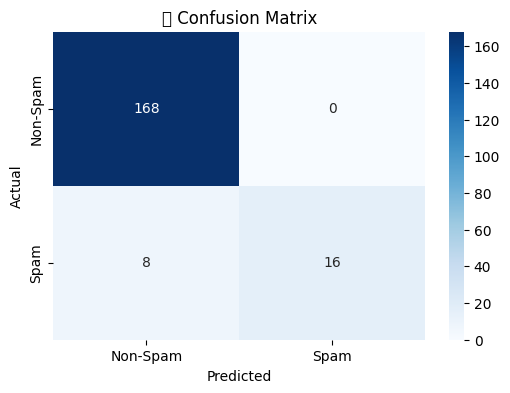

<Figure size 800x400 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


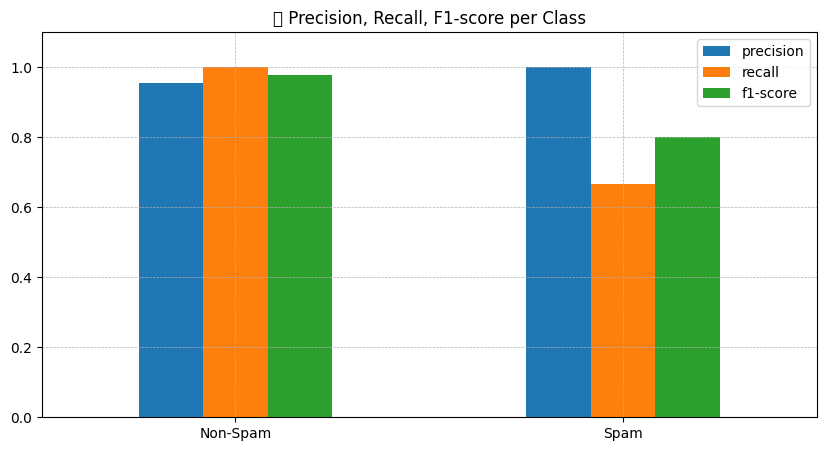

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Predict with the best model
y_pred = grid.predict(X_test)

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=grid.best_estimator_.classes_)
labels = grid.best_estimator_.classes_

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.title("📊 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 3. Classification Report Bar Plot
report = classification_report(y_test, y_pred, output_dict=True, target_names=labels)
report_df = pd.DataFrame(report).transpose().drop(['accuracy', 'macro avg', 'weighted avg'])

plt.figure(figsize=(8, 4))
report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 5))
plt.title("📈 Precision, Recall, F1-score per Class")
plt.ylim(0, 1.1)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.xticks(rotation=0)
plt.show()
